Set OBSGEO-B to    -6.423449 from OBSGEO-[XYZ].
Set OBSGEO-H to 1338407622.672 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-09-09T20:12:50.680' from MJD-AVG.
Set DATE-END to '2023-09-09T22:16:17.386' from MJD-END'. [astropy.wcs.wcs]


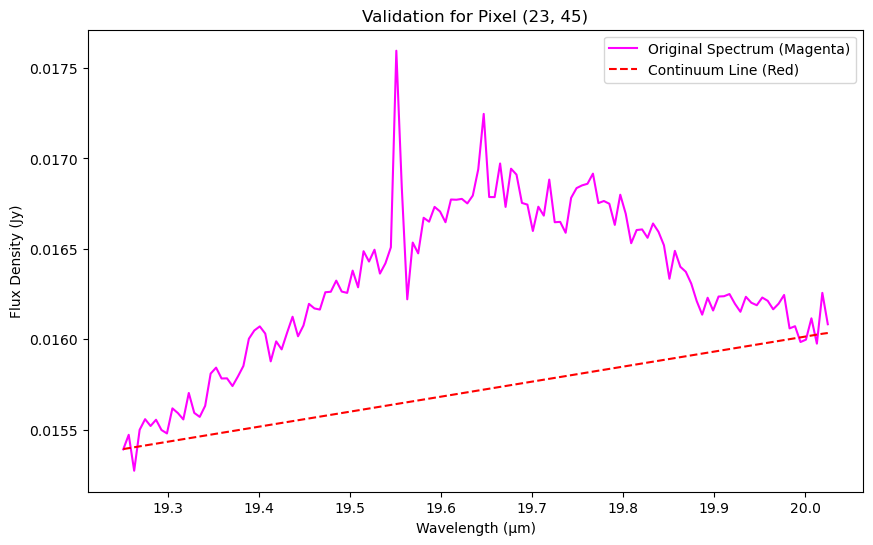

Fraction of negative values: 14.63%
residual FITS file saved at 19.25orginalflux-continuum_22.4-24.05_corrected.fits


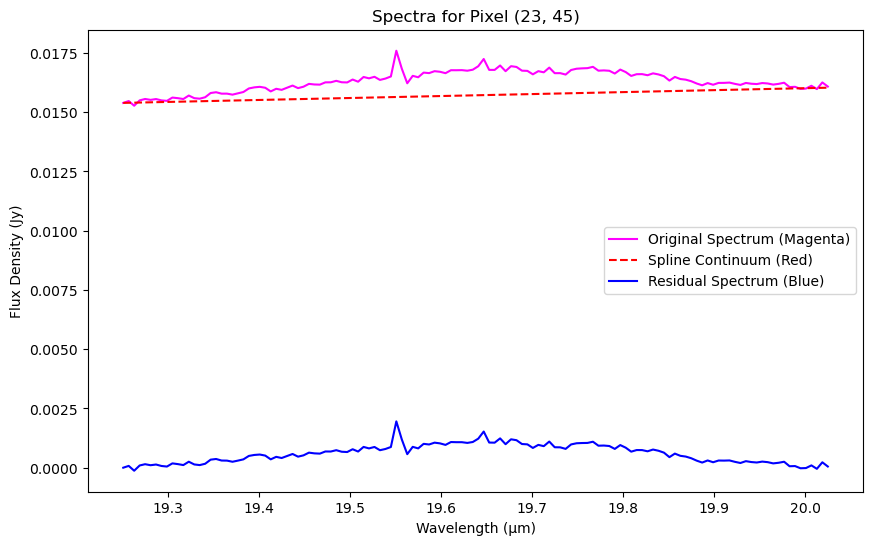

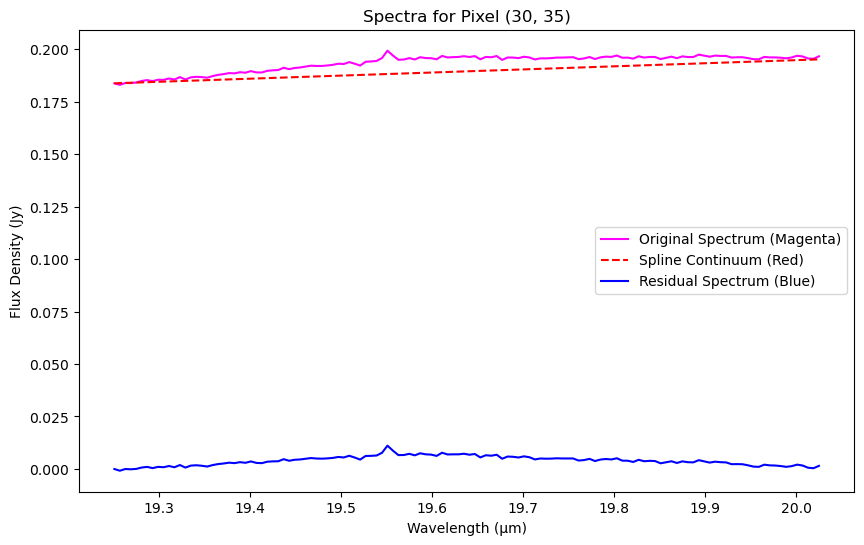

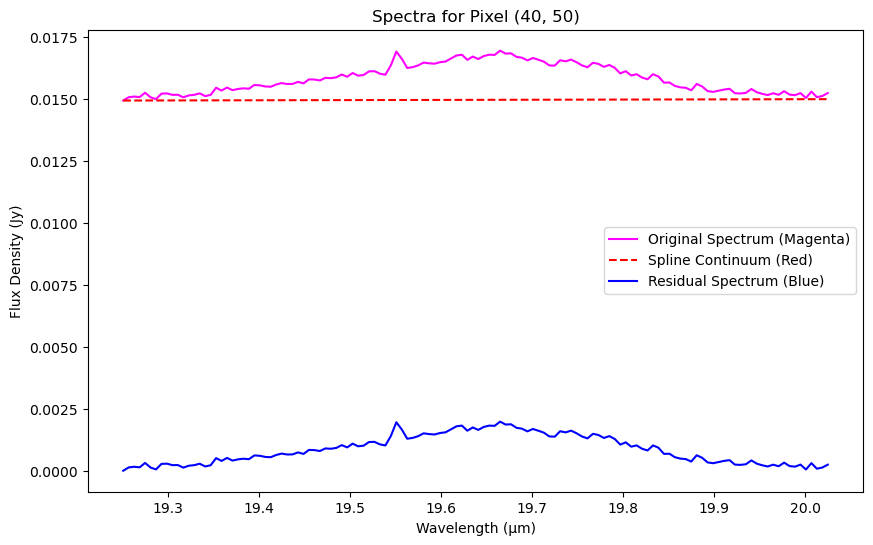

Negative values fraction: 14.63%
Positive values fraction: 53.49%


/var/folders/lr/h4dkpmd15k5876fbm2bxtr000000gn/T/ipykernel_22222/2261734268.py:96: RuntimeWarning: Mean of empty slice
  mean_residual = np.nanmean(residual, axis=0)
/var/folders/lr/h4dkpmd15k5876fbm2bxtr000000gn/T/ipykernel_22222/2261734268.py:106: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(


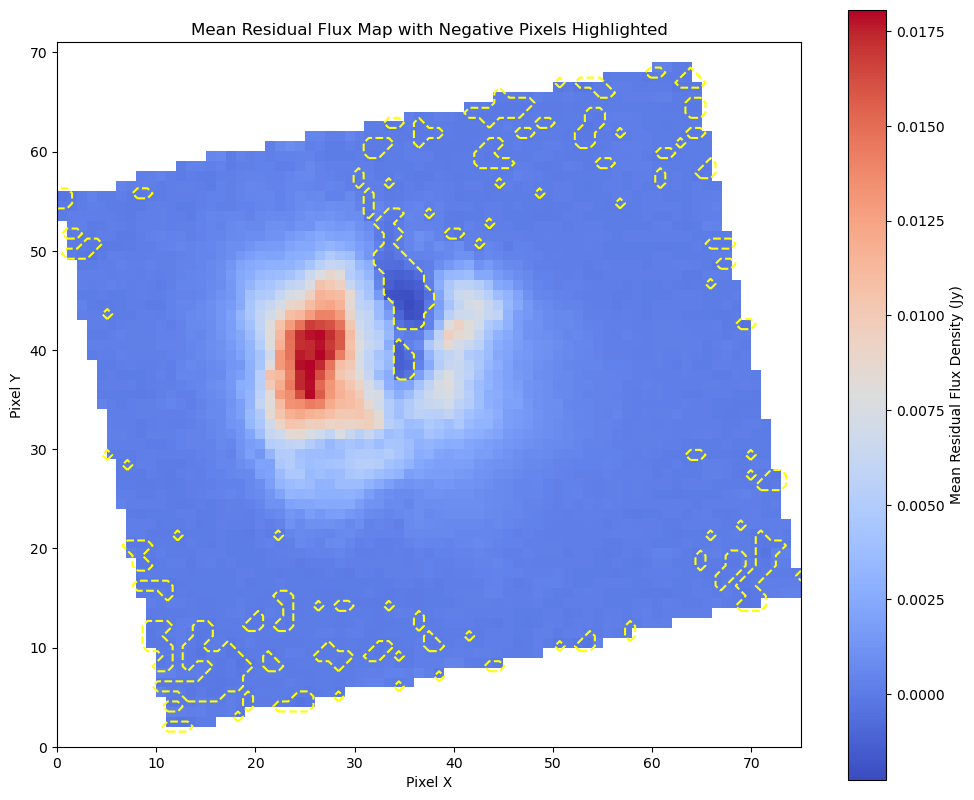

Number of negative pixels: 310
Negative pixel indices (Y, X):
[ 2 11]
[ 2 12]
[ 2 13]
[ 3 18]
[ 4 11]
[ 4 12]
[ 4 19]
[ 4 22]
[ 4 23]
[ 4 24]


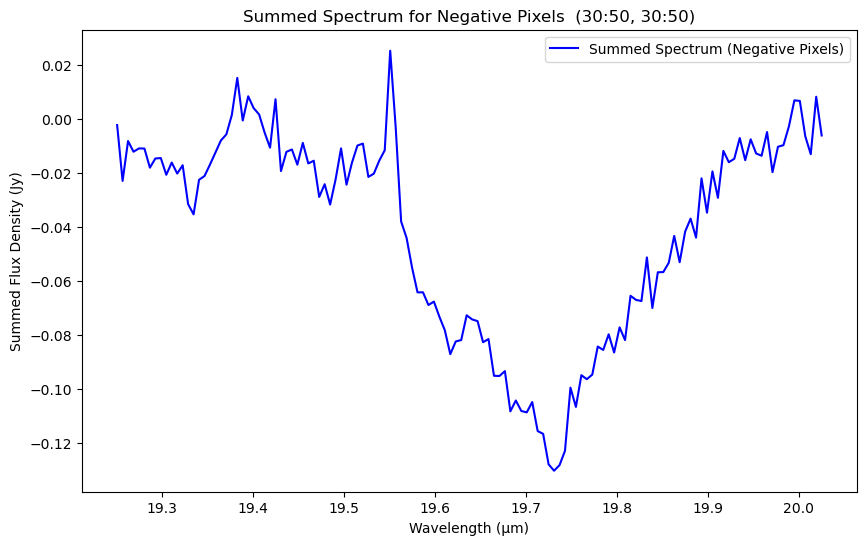

Negative pixel  (30:50, 30:50): [(37, 34), (37, 35), (38, 34), (38, 35), (39, 34), (39, 35), (40, 34), (42, 34), (42, 35), (42, 36), (43, 34), (43, 35), (43, 36), (44, 34), (44, 35), (44, 36), (44, 37), (45, 33), (45, 34), (45, 35), (45, 36), (45, 37), (46, 33), (46, 34), (46, 35), (46, 36), (47, 33), (47, 34), (47, 35), (47, 36), (48, 32), (48, 33), (48, 34), (48, 35), (49, 32), (49, 33), (49, 34), (50, 33), (50, 42)]
Total summed flux across the wavelength range: -5.341323


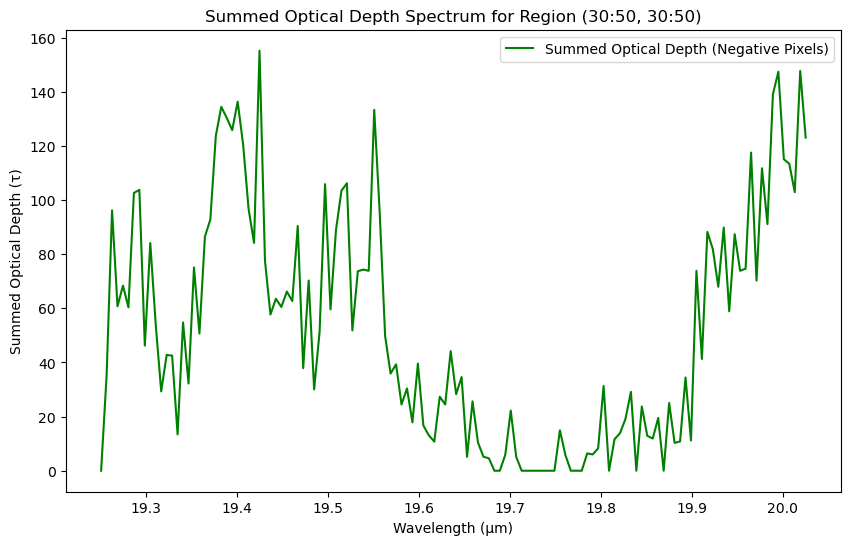

Signal (mean of negative values): 0.000194
Noise (standard deviation of negative values): 0.000416
Signal-to-Noise Ratio (SNR): 0.47


In [4]:
import numpy as np
from astropy.io import fits
from mpdaf.obj import Cube
from astropy import units as u
import matplotlib.pyplot as plt

cube_path = '/Users/mary/Fits image of JWST/ngc6302_ch4-short_s3d.fits'
continuum_path = '19.25continuum_line.fits'
output_path = '19.25orginalflux-continuum_22.4-24.05_corrected.fits'

cube = Cube(cube_path)
pixel_size_arcsec = cube.wcs.get_step(unit=u.arcsec)[0] 
solid_angle = (pixel_size_arcsec * u.arcsec).to(u.rad)**2  
flux_density = cube.data * solid_angle.value * 1e6 


with fits.open(continuum_path) as hdul:
    continuum_data = hdul[0].data
    continuum_header = hdul[0].header
    continuum_crval3 = continuum_header['CRVAL3']
    continuum_cdelt3 = continuum_header['CDELT3']
    continuum_naxis3 = continuum_data.shape[0]
    continuum_wavelengths = continuum_crval3 + np.arange(continuum_naxis3) * continuum_cdelt3


wavelengths = cube.wave.coord()
range_min, range_max = 19.25, 20.03
mask = (wavelengths >= range_min) & (wavelengths <= range_max)
filtered_flux_density = flux_density[mask, :, :] 
filtered_wavelengths = wavelengths[mask] 


aligned_continuum = np.zeros_like(filtered_flux_density)
for y in range(filtered_flux_density.shape[1]):
    for x in range(filtered_flux_density.shape[2]):
        aligned_continuum[:, y, x] = np.interp(filtered_wavelengths, continuum_wavelengths, continuum_data[:, y, x])

# Debug
y_pixel, x_pixel = 23, 45  
original_spectrum = filtered_flux_density[:, y_pixel, x_pixel]
continuum_spectrum = aligned_continuum[:, y_pixel, x_pixel]

plt.figure(figsize=(10, 6))
plt.plot(filtered_wavelengths, original_spectrum, label="Original Spectrum (Magenta)", color="magenta")
plt.plot(filtered_wavelengths, continuum_spectrum, label="Continuum Line (Red)", color="red", linestyle="--")
plt.xlabel("Wavelength (μm)")
plt.ylabel("Flux Density (Jy)")
plt.legend()
plt.title(f"Validation for Pixel ({y_pixel}, {x_pixel})")
plt.savefig("fd")
plt.show()

residual = filtered_flux_density - aligned_continuum


negative_fraction = np.sum(residual < 0) / residual.size
print(f"Fraction of negative values: {negative_fraction:.2%}")


if np.ma.isMaskedArray(residual):
    residual = residual.filled(np.nan)  

cube_header = fits.getheader(cube_path, ext=1)
cube_header['CRVAL3'] = range_min 
cube_header['CDELT3'] = continuum_cdelt3  
cube_header['NAXIS3'] = len(filtered_wavelengths)  

fits.writeto(output_path, residual.astype('float32'), header=cube_header, overwrite=True)
print(f"residual FITS file saved at {output_path}")

# Debug: Check 
debug_pixels = [(23, 45), (30, 35), (40, 50)]  # Example pixels
for y_pixel, x_pixel in debug_pixels:
    original_spectrum = filtered_flux_density[:, y_pixel, x_pixel]
    continuum_spectrum = aligned_continuum[:, y_pixel, x_pixel]
    residual_spectrum = residual[:, y_pixel, x_pixel]

  
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_wavelengths, original_spectrum, label="Original Spectrum (Magenta)", color="magenta")
    plt.plot(filtered_wavelengths, continuum_spectrum, label="Spline Continuum (Red)", color="red", linestyle="--")
    plt.plot(filtered_wavelengths, residual_spectrum, label="Residual Spectrum (Blue)", color="blue")
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Flux Density (Jy)")
    plt.legend()
    plt.title(f"Spectra for Pixel ({y_pixel}, {x_pixel})")
    plt.savefig(f"Spectra_for_Pixel_{y_pixel}_{x_pixel}.png")
    plt.show()

# Debug: Check 
negative_fraction = np.sum(residual < 0) / residual.size
positive_fraction = np.sum(residual > 0) / residual.size
print(f"Negative values fraction: {negative_fraction:.2%}")
print(f"Positive values fraction: {positive_fraction:.2%}")

mean_residual = np.nanmean(residual, axis=0) 

negative_pixel_mask = mean_residual < 0

plt.figure(figsize=(12, 10))
plt.imshow(mean_residual, origin='lower', cmap='coolwarm', extent=(0, mean_residual.shape[1], 0, mean_residual.shape[0]))
plt.colorbar(label="Mean Residual Flux Density (Jy)")
plt.title("Mean Residual Flux Map with Negative Pixels Highlighted")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.contour(
    negative_pixel_mask,
    levels=[0.5],
    colors="yellow",
    linewidths=1.5,
    linestyles="--",
    extent=(0, mean_residual.shape[1], 0, mean_residual.shape[0]),
    label="Negative Pixels"
)


plt.savefig("Mean_Residual_Map_With_Negative_Pixels.png", dpi=300)
plt.show()

# Debug:check
num_negative_pixels = np.sum(negative_pixel_mask)
print(f"Number of negative pixels: {num_negative_pixels}")
print(f"Negative pixel indices (Y, X):")
negative_pixel_indices = np.argwhere(negative_pixel_mask)
for idx in negative_pixel_indices[:10]: 
    print(idx)

y1, y2 = 30, 50
x1, x2 = 30, 50


negative_pixel_indices = [
    (y, x) for y, x in negative_pixel_indices if y1 <= y <= y2 and x1 <= x <= x2
]

if not negative_pixel_indices:
    print("No negative pixels found in the specified region.")
else:
   
    summed_spectrum = np.zeros(residual.shape[0])

    for y, x in negative_pixel_indices:
        residual_spectrum = residual[:, y, x]
        summed_spectrum += residual_spectrum

   
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_wavelengths, summed_spectrum, label="Summed Spectrum (Negative Pixels)", color="blue")
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Summed Flux Density (Jy)")
    plt.title(f"Summed Spectrum for Negative Pixels  ({y1}:{y2}, {x1}:{x2})")
    plt.legend()
    plt.savefig("Summed_Spectrum_Negative_Pixels.png", dpi=300)
    plt.show()

    
    print(f"Negative pixel  ({y1}:{y2}, {x1}:{x2}): {negative_pixel_indices}")
    print(f"Total summed flux across the wavelength range: {np.sum(summed_spectrum):.6f}")

y1, y2 = 30, 50
x1, x2 = 30, 50

negative_pixel_indices = [
    (y, x) for y, x in negative_pixel_indices if y1 <= y <= y2 and x1 <= x <= x2
]

summed_tau = np.zeros(len(filtered_wavelengths))

for y, x in negative_pixel_indices:
    residual_spectrum = residual[:, y, x]
    continuum_spectrum = aligned_continuum[:, y, x]

    with np.errstate(divide='ignore', invalid='ignore'):
        tau = -np.log(np.where(residual_spectrum > 0, residual_spectrum / continuum_spectrum, np.nan))
  
    summed_tau += np.nan_to_num(tau)  

plt.figure(figsize=(10, 6))
plt.plot(filtered_wavelengths, summed_tau, label="Summed Optical Depth (Negative Pixels)", color="green")
plt.xlabel("Wavelength (\u03bcm)")
plt.ylabel("Summed Optical Depth (\u03c4)")
plt.title(f"Summed Optical Depth Spectrum for Region ({y1}:{y2}, {x1}:{x2})")
plt.legend()
plt.savefig("Summed_Optical_Depth_Negative_Pixels.png", dpi=300)
plt.show()

negative_values = residual[residual < 0]

if negative_values.size > 0:

    signal = np.abs(np.mean(negative_values))  
    noise = np.std(negative_values)          
    
    snr = signal / noise if noise != 0 else np.inf

    print(f"Signal (mean of negative values): {signal:.6f}")
    print(f"Noise (standard deviation of negative values): {noise:.6f}")
    print(f"Signal-to-Noise Ratio (SNR): {snr:.2f}")
else:
    print("No negative values found in the residual.")

